In [1]:
%matplotlib inline
import os
import xml.dom.minidom as minidom
import matplotlib.pyplot as plt
import pandas as pd
import datapackage
import ome_files
import ome_files.metadata as ofmd
import isatools.io.isatab_parser as isatab_parser
import biotracks.cmso as cmso
from biotracks.readfile import BiotracksReader

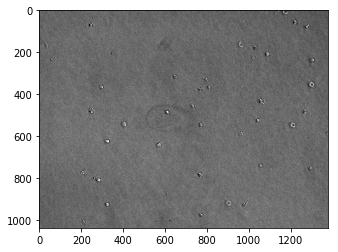

In [2]:
old_cwd = os.getcwd()
os.chdir(os.path.join("UGent", "BaF3"))
reader = ome_files.OMETIFFReader()
reader.set_id("9I5TT808_F00000010.companion.ome")
pixels = reader.open_array(0)
ome_xml = reader.get_ome_xml()
meta = ofmd.OMEXMLMetadata(ome_xml)
reader.close()
plt.imshow(pixels, cmap="gray")

In [3]:
cmso_annotations = [_ for _ in meta.get_map_annotations() if _.Namespace == "CMSO/isa"]
assert len(cmso_annotations) == 1
ann = cmso_annotations[0]
paths = ann.Value.get("FilePath")
print(paths)

['isatab/i_Investigation.txt']


In [4]:
isa_path = os.path.abspath(paths[0])  # Relative path does not work. isatools bug?
rec = isatab_parser.parse(isa_path)

inserting Protocol REF.3 at position 46
inserting Protocol REF.3 at position 46


In [5]:
study = rec.studies[0]
print(study.metadata["Study Title"])

Ba/F3 cell line expressing 3 distinct 2BCR-ABL constructs exposed to Rock inhibitors


In [6]:
cmso_annotations = [_ for _ in meta.get_map_annotations() if _.Namespace == "CMSO/dpkg"]
assert len(cmso_annotations) == 1
ann = cmso_annotations[0]
paths = ann.Value.get("FilePath")
print(paths)

['cellmia/datapackage.json', 'trackmate/datapackage.json']


In [7]:
dataframes = {}
for dp_fn in paths:
    reader = BiotracksReader(dp_fn)
    reader.read()
    df = reader.objects
    df0 = df[df[cmso.FRAME_ID] == 0]
    dataframes[dp_fn] = df0
    print("\n%s:" % dp_fn)
    print(df0.head())


cellmia/datapackage.json:
     cmso_object_id  cmso_frame_id  cmso_x_coord  cmso_y_coord
0                 0              0   1170.187500      2.187500
22               22              0   1274.867925     78.603774
56               56              0    807.500000    367.000000
156             156              0   1026.035088    180.561404
242             242              0   1040.210526    525.631579

trackmate/datapackage.json:
   cmso_object_id  cmso_frame_id  cmso_x_coord  cmso_y_coord
0            4944              0    374.808007      0.000000
1            4945              0    379.580211      5.092978
2            4946              0    393.821457     17.832669
3            4947              0    411.600018     24.898522
4            4948              0    183.139192     48.351896


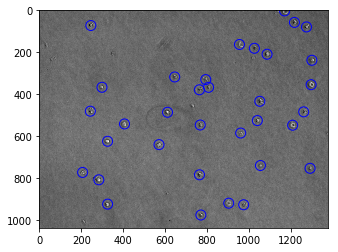

In [8]:
def plot_overlay(dp_fn, x_scale=1.0, y_scale=1.0):
    df = dataframes[dp_fn]
    x, y = x_scale * df[cmso.X_COORD].values, y_scale * df[cmso.Y_COORD].values
    plt.scatter(x=x, y=y, s=100, edgecolors='b', facecolors='none')
    plt.imshow(pixels, cmap="gray")
    plt.show()
plot_overlay("cellmia/datapackage.json")

In [9]:
# TrackMate outputs coordinates as physical size
doc = minidom.parseString(ome_xml)
pixel_nodes = doc.getElementsByTagName("Pixels")
assert len(pixel_nodes) == 1
node = pixel_nodes[0]
x_scale = 1 / float(node.getAttribute("PhysicalSizeX"))
y_scale = 1 / float(node.getAttribute("PhysicalSizeY"))
print(x_scale, y_scale)

3.1055900621118013 3.1055900621118013


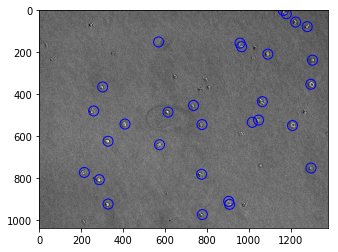

In [10]:
plot_overlay("trackmate/datapackage.json", x_scale, y_scale)

In [11]:
os.chdir(old_cwd)